# Optimization Study

- stop criteria: 

In [1]:
%config Completer.use_jedi = False

In [2]:
import math
import numpy as np
import pandas as pd
from cmaes import CMA
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist

## Objective Function

In [3]:
def ackley(x1, x2):
    # https://www.sfu.ca/~ssurjano/ackley.html
    return (
        -20 * math.exp(-0.2 * math.sqrt(0.5 * (x1 ** 2 + x2 ** 2)))
        - math.exp(0.5 * (math.cos(2 * math.pi * x1) + math.cos(2 * math.pi * x2)))
        + math.e + 20
    )

def errorfcn(alpha, Xbar, n, m):
    f1 = np.reshape(alpha[(2 * n):], (m, 2))
    f2 = np.reshape(alpha[0:2 * n], (2, n))
    f3 = Xbar[:, 0:n].T
    r = (Xbar - np.dot(f1, np.dot(f2, f3)).T) ** 2
    return np.nanmean(np.nanmean(r, axis=0))

In [4]:
bounds = np.array([[-32.768, 32.768], [-32.768, 32.768]])
lower_bounds, upper_bounds = bounds[:, 0], bounds[:, 1]

mean = lower_bounds + (np.random.rand(2) * (upper_bounds - lower_bounds))
sigma = 32.768 * 2 / 5  # 1/5 of the domain width
optimizer = CMA(mean=mean, sigma=sigma, bounds=bounds, seed=0)

for generation in range(200):
    solutions = []
    for _ in range(optimizer.population_size):
        x = optimizer.ask()
        value = ackley(x[0], x[1])
        solutions.append((x, value))
#         print(f"#{generation} {value} (x1={x[0]}, x2 = {x[1]})")
    optimizer.tell(solutions)

    if optimizer.should_stop():
        # popsize multiplied by 2 (or 3) before each restart.
        popsize = optimizer.population_size * 2
        mean = lower_bounds + (np.random.rand(2) * (upper_bounds - lower_bounds))
        optimizer = CMA(mean=mean, sigma=sigma, population_size=popsize)
        print(f"Restart CMA-ES with popsize={popsize}")


Restart CMA-ES with popsize=12
Restart CMA-ES with popsize=24


In [5]:
import os

synthetic_datasets = os.listdir('datasets/sklearn-datasets')
real_datasets = os.listdir('datasets/real-datasets')

In [6]:
datasets_dictionary = dict()
for f in synthetic_datasets:
    try:
        df = pd.read_csv(f'datasets/sklearn-datasets/{f}')
        target_columns = [col for col in df.columns if col.startswith('target')]
        datasets_dictionary[f] = (df, target_columns)
    except:
        pass

for f in real_datasets:
    try:
        df = pd.read_csv(f'datasets/real-datasets/{f}').drop(columns = ['instances'])
        target_columns = [col for col in df.columns if col.startswith('algo')]
        datasets_dictionary[f] = (df, target_columns)
    except:
        pass

In [7]:
df_teste = pd.read_csv('datasets/real-datasets/XOR_metadata.csv').drop(columns = ['instances'])
performance_columns = [col for col in df.columns if col.startswith('algo')]

In [8]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   feature_kDN               1000 non-null   float64
 1   feature_DS                1000 non-null   float64
 2   feature_TD_P              1000 non-null   float64
 3   feature_TD_U              1000 non-null   float64
 4   feature_CLD               1000 non-null   float64
 5   feature_N1                1000 non-null   float64
 6   feature_N2                1000 non-null   float64
 7   feature_LSR               1000 non-null   float64
 8   feature_Harmfulness       1000 non-null   float64
 9   feature_Usefulness        1000 non-null   float64
 10  algo_bagging              1000 non-null   float64
 11  algo_dummy                1000 non-null   float64
 12  algo_gradient_boosting    1000 non-null   float64
 13  algo_logistic_regression  1000 non-null   float64
 14  algo_mlp 

## IPOP-CMA-ES

In [9]:
from dataclasses import dataclass

@dataclass
class PilotOutput:
    A: np.ndarray
    B: np.ndarray
    C: np.ndarray
    Z: np.ndarray
    error: float
    execution_time: float

In [10]:
import time


def ipop_cma_es(X, Y, **kwargs):
    np.random.seed(0)
    
    Xbar = np.hstack((X, Y))
    n = X.shape[1]
    m = Xbar.shape[1]
    
    if 'search_space' not in kwargs:
        search_space = 32.768
    else:
        search_space = kwargs['search_space']
        
    bounds = list()
    bounds.append([[-search_space, search_space] for i in range(2 * m + 2 * n)])
    bounds = np.array(bounds).reshape((2 * m + 2 * n, 2))

    lower_bounds, upper_bounds = bounds[:, 0], bounds[:, 1]
    mean = lower_bounds + (np.random.rand(2 * m + 2 * n) * (upper_bounds - lower_bounds))
    sigma = search_space * 2 / 5  # 1/5 of the domain width

    optimizer = CMA(mean=mean, sigma=sigma, bounds=bounds, seed=0)
    
    if 'ntries' not in kwargs:
        ntries = 100
    else:
        ntries = kwargs['ntries']
        
    perf = np.zeros(ntries)
    alpha = np.zeros((2 * m + 2 * n, ntries))
    Hd = pdist(X)[np.newaxis].T
    
    start_time = time.time()
    for generation in range(ntries):
        solutions = []

        for _ in range(optimizer.population_size):
            # Sample parameters to evaluate function
            alpha[:, generation] = optimizer.ask()

            # Calculate function value
            value = errorfcn(alpha = alpha[:, generation], Xbar = Xbar, n = n, m = m)
            solutions.append((alpha[:, generation], value))
    #     print(f"#{generation} {value}")

        optimizer.tell(solutions)
    #     print('shape alpha', alpha.shape, "alpha\n", alpha)
        aux = alpha[:, [generation]]
        A = np.reshape(aux[0:2 * n], (2, n))
        Z = np.dot(X, A.T)
        perf[generation] = np.corrcoef(Hd, pdist(Z)[np.newaxis].T, rowvar=False)[0][1]

        # Restart
        if optimizer.should_stop():
            print('Optimizer should stop')
            # popsize multiplied by 2 (or 3) before each restart.
            popsize = optimizer.population_size * 2

            mean = lower_bounds + (np.random.rand(2 * m + 2 * n) * (upper_bounds - lower_bounds))
            optimizer = CMA(mean=mean, sigma=sigma, population_size=popsize)
            print(f"Restart CMA-ES with popsize={popsize}")
    end_time = time.time()
    
    idx = np.argmax(perf)
    A = np.reshape(alpha[0:2 * n, idx], (2, n))
    Z = np.dot(X, A.T)
    B = np.reshape(alpha[(2 * n):, idx], (m, 2))
    Xhat = np.dot(Z, B.T)
    C = B[n:m + 1, :].T
    B = B[0:n + 1, :]
    error = np.sum((Xbar - Xhat) ** 2)
    execution_time = end_time - start_time
    out = PilotOutput(A, B, C, Z, error, execution_time)
    return out

In [11]:
def run_optimization(df, target_columns, optimization_method, **kwargs):
    X = df.drop(columns = target_columns)
    Y = df[target_columns]
    output = optimization_method(X, Y, **kwargs)
    return output

In [12]:
%%time
ipop_output = run_optimization(df_teste, performance_columns, ipop_cma_es, ntries = 5)

CPU times: user 644 ms, sys: 14.7 ms, total: 659 ms
Wall time: 343 ms


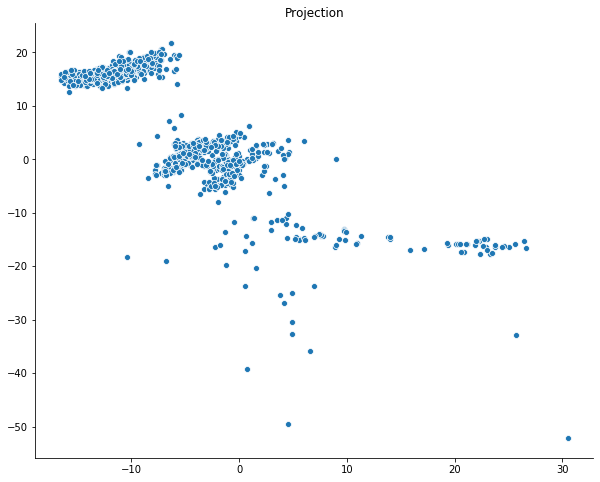

In [13]:
def plot_scatter_plot(x, y, title = None, x_label = None, y_label = None):
    fig, ax = plt.subplots(figsize = (10, 8))
    sns.scatterplot(x = x, y = y)
    ax.set_title(title)
    sns.despine()
    
plot_scatter_plot(x = ipop_output.Z[:, 0], y = ipop_output.Z[:, 1], title = "Projection")

In [14]:
%%time
experiments = dict()
for filename, item in datasets_dictionary.items():
#     print(f"Optimizing for {filename} dataset")
#     print(f"Target columns {item[1]}\n-------------\n\n")
    experiments[filename] = run_optimization(df = item[0], target_columns = item[1], optimization_method=ipop_cma_es, ntries = 100)

CPU times: user 42min 22s, sys: 23 s, total: 42min 45s
Wall time: 22min 11s


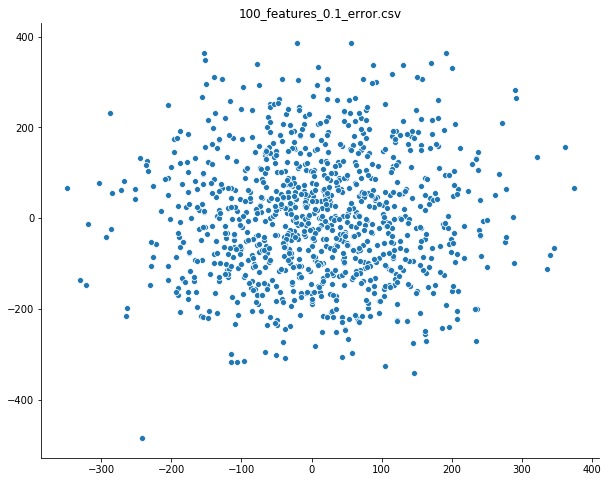

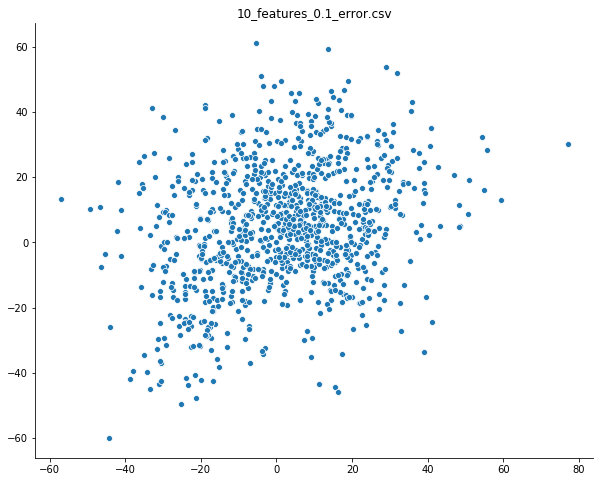

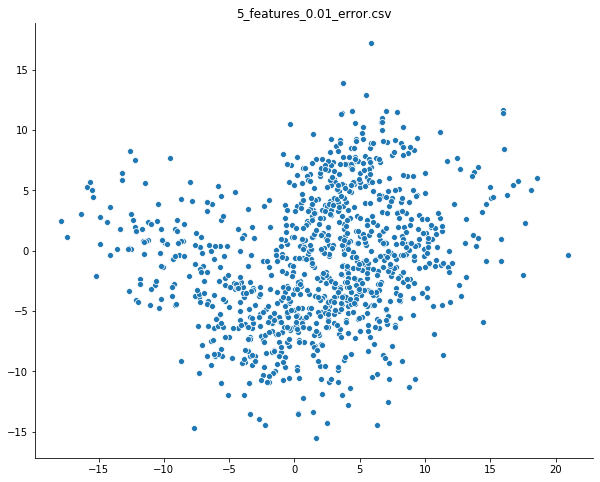

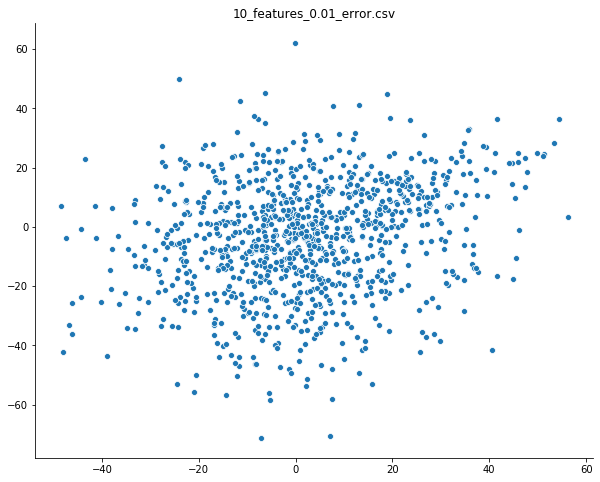

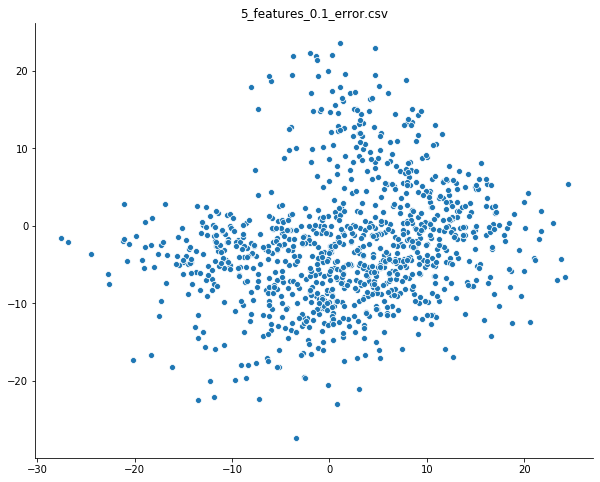

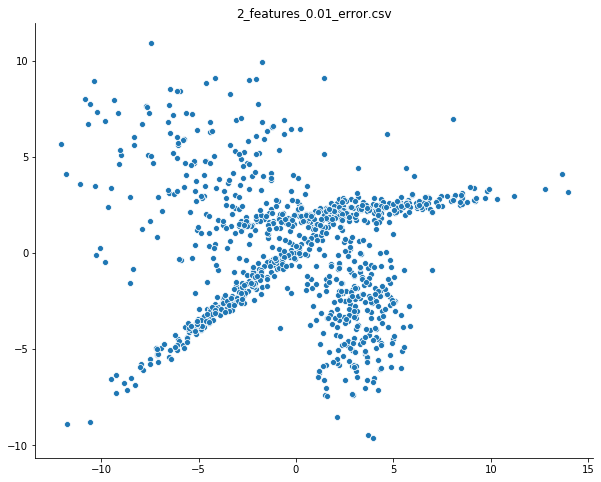

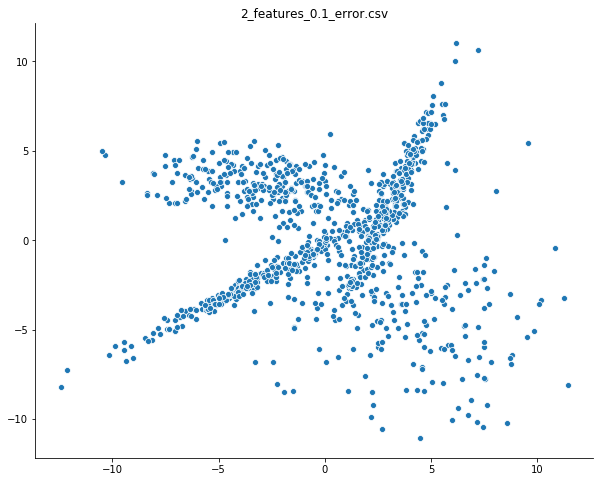

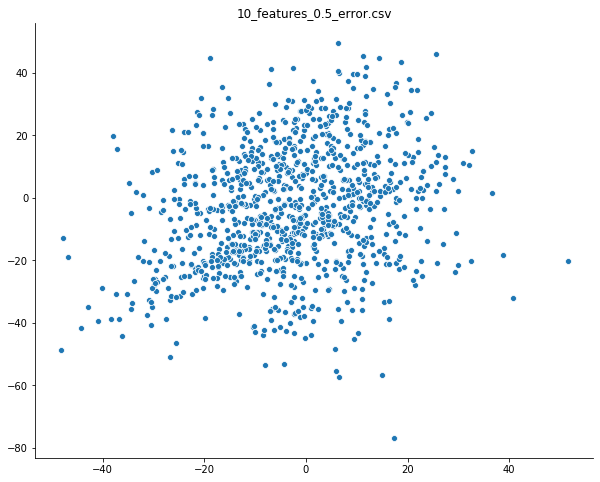

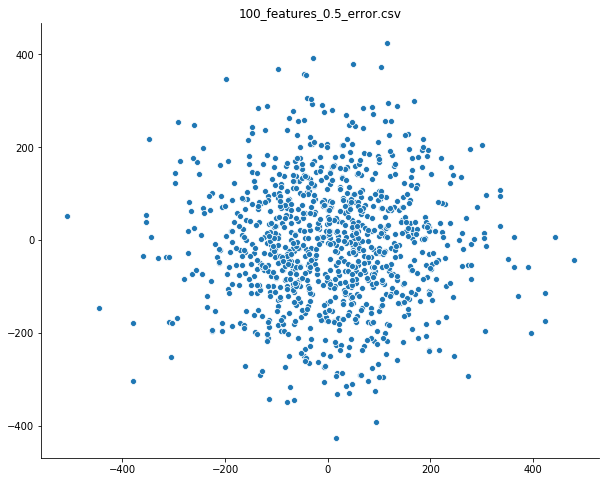

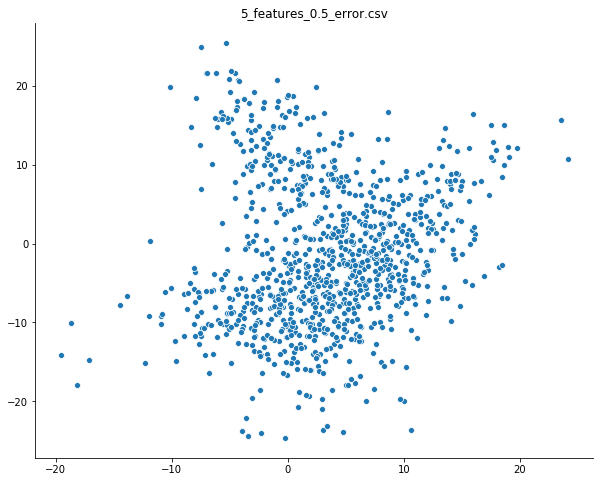

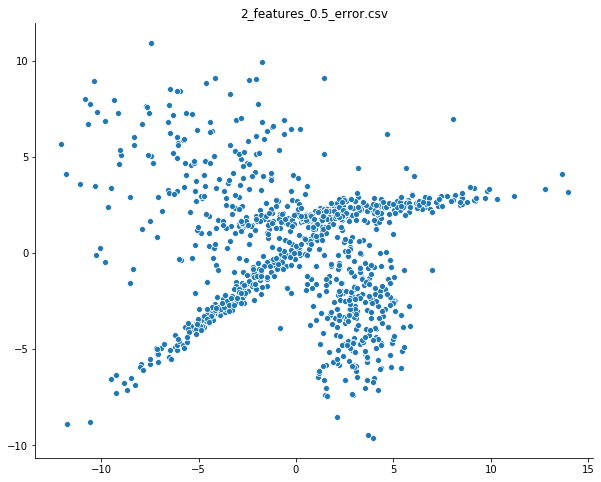

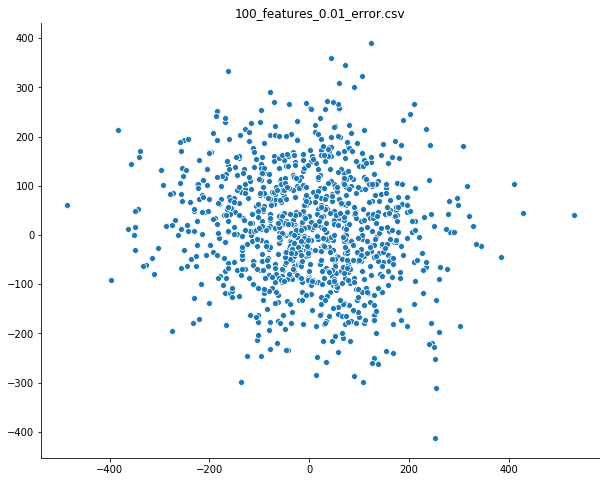

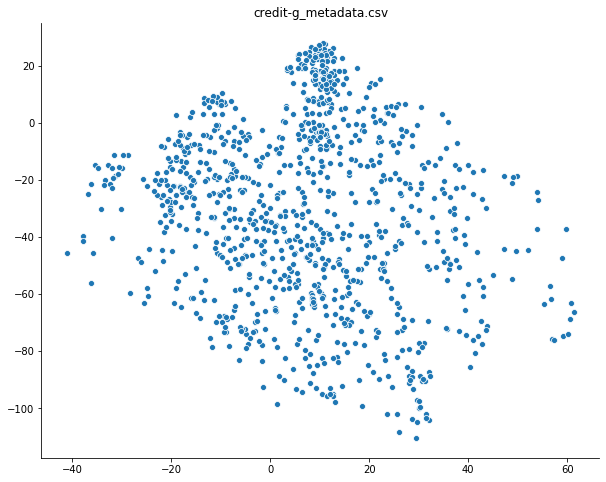

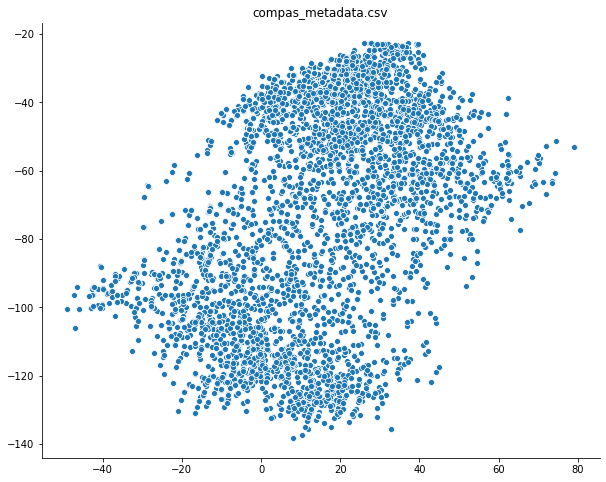

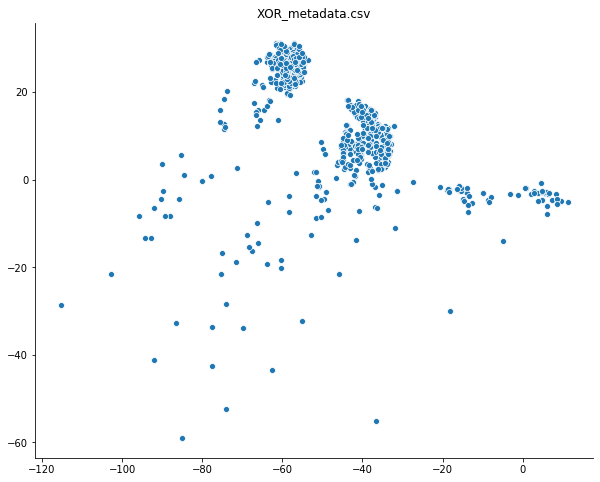

In [15]:
for dataset_filename in experiments.keys():
    plot_scatter_plot(x = experiments[dataset_filename].Z[:, 0],
                     y = experiments[dataset_filename].Z[:, 1],
                     title = dataset_filename)

In [16]:
ipop_results_df = pd.DataFrame()

ipop_results_df['dataset'] = experiments.keys()
ipop_results_df['error'] = [experiments[dataset_filename].error for dataset_filename in experiments.keys()]
ipop_results_df['execution_time'] = [experiments[dataset_filename].execution_time for dataset_filename in experiments.keys()]

ipop_results_df

,dataset,error,execution_time
0,100_features_0.1_error.csv,1.599999e+12,419.651388
1,10_features_0.1_error.csv,3.017512e+09,5.543430
2,5_features_0.01_error.csv,9.692699e+07,3.758367
3,10_features_0.01_error.csv,4.315099e+09,6.710717
4,5_features_0.1_error.csv,6.507791e+08,3.841306
5,2_features_0.01_error.csv,3.408731e+07,1.145961
6,2_features_0.1_error.csv,3.391901e+07,1.154266
7,10_features_0.5_error.csv,4.067444e+09,8.826646
8,100_features_0.5_error.csv,1.900143e+12,408.491283
9,5_features_0.5_error.csv,2.571481e+08,3.858822


In [18]:
ipop_results_df.to_excel('results/ipop-results.xlsx')

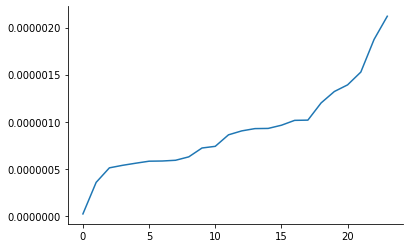

In [17]:
function_values = [s[1] for s in solutions] 

sns.lineplot(x = [i for i in range(len(function_values))],
             y = function_values)
sns.despine()